In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os

Mounted at /content/drive


Описание задания - https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/overview

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score,\
learning_curve, TimeSeriesSplit, GridSearchCV
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import torch
import torch.nn as nn
from IPython.display import clear_output
import re
import pickle
from gensim.models import FastText
from gensim.test.utils import get_tmpfile
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from datetime import datetime
import copy
from functools import lru_cache
import random

In [ ]:
colab = True
if colab:
    PATH_TO_TRAIN = 'drive/My Drive/catch_me_test_sessions.csv'
    PATH_TO_TEST = 'drive/My Drive/catch_me_train_sessions.csv'
    PATH_TO_PICKLE = 'drive/My Drive/site_dic.pkl'
    PATH_TO_TF_IDF = 'drive/My Drive/tf_idf_embeddings.csv'
else:
    PATH_TO_TRAIN = 'catch_me_test_sessions.csv'
    PATH_TO_TEST = 'catch_me_train_sessions.csv'
    PATH_TO_PICKLE = '../site_dic.pkl'
PREDICT_FILENAME = 'catch_me_preds.csv'
test = pd.read_csv(PATH_TO_TRAIN)
data = pd.read_csv(PATH_TO_TEST)
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]
data = data.drop_duplicates(subset = sites)
data = data.reset_index().drop(['session_id', 'index'], axis = 1)
data['index'] = [i for i in data.index]

In [ ]:
with open(PATH_TO_PICKLE, 'rb') as f:
    sites_dict = pickle.load(f)

In [ ]:
sites_dict['padding'] = 0
id_sites_dict = {sites_dict[site_name]:site_name for site_name in sites_dict}

after_dot = Counter()
for site_name in sites_dict:
    after_dot.update({site_name.split('.')[-1]})

after_dot = set(dict(after_dot.most_common(35)).keys())

In [ ]:
corrected_site_name = []
for id_site in id_sites_dict:
    array_site_name = id_sites_dict[id_site].split('.')
    if array_site_name[0] == 'www':
        del array_site_name[0]
    if array_site_name[-1] in after_dot:
        del array_site_name[-1]
    id_sites_dict[id_site] = '.'.join(array_site_name)

In [ ]:
data.fillna(0, inplace = True)
test.fillna(0, inplace = True)
data[sites] = data[sites].applymap(lambda id: id_sites_dict[id])
test[sites] = test[sites].applymap(lambda id: id_sites_dict[id])

In [ ]:
model_ft = FastText.load('drive/My Drive/ft_model.model')
clustering_model = None

In [ ]:
class Prepare:
    def __init__(self, train, test, target_column : str = 'target', model_ft = model_ft, **kwargs):
        self.train = train
        self.test = test
        self.target_column = target_column
        self.target = train[target_column]
        self.unknown_idx = -1
        self.pad_idx = 0
        self.model_ft = model_ft
        self.embedding_dim = 128
        self.mean_embedding_columns = None
        self.clustering_mean = True
        self.clustering_tf_idf = False


    def _get_vector(self, x):
       return self.model_ft[x]


    def prepare_df (self):
        train = self.train
        test = self.test
        train[times] = train[times].apply(pd.to_datetime)
        test[times] = test[times].apply(pd.to_datetime)
        train = train.sort_values('time1')
        train = self._create_cat_features(train)
        test = self._create_cat_features(test)
        if self.clustering_mean:
          self.train = self._add_mean_embedding_columns(train)
          self.test = self._add_mean_embedding_columns(test)


    def _create_cat_features(self, df):
        cat = 'cat_'
        df[f'{cat}hour'] = df['time1'].apply(lambda time: time.hour)
        df[f'{cat}morning'] = ((df[f'{cat}hour'] >= 7) & (df[f'{cat}hour'] <= 11)).astype('int')
        df[f'{cat}day'] = ((df[f'{cat}hour'] >= 12) & (df[f'{cat}hour'] <= 18)).astype('int')
        df[f'{cat}evening'] = ((df[f'{cat}hour'] >= 19) & (df[f'{cat}hour'] <= 23)).astype('int')
        df[f'{cat}day_of_week'] = df['time1'].apply(lambda t: t.weekday()).astype('int')
        df[f'{cat}weekend'] = df[f'{cat}day_of_week'].isin([5,6]).astype('int')
        cat_columns = list(filter(lambda col: col[:4] == 'cat_', df.columns))
        for cat_column in cat_columns:
          df = pd.concat([df, pd.get_dummies(df[cat_column], prefix = cat_column)], axis = 1)
          df.drop([cat_column], axis = 1, inplace = True)
        self.cat_columns = list(filter(lambda col: col[:4] == 'cat_', df.columns))
        return df


    def _add_mean_embedding_columns(self, df):
        if self.mean_embedding_columns is None:
          self.mean_embedding_columns = [f'mean_embeding_{idx}' for idx in range(self.embedding_dim)]
        mean_embeddings_df = np.array(list(map(self._get_vector,df[sites].values))).mean(axis = 1)
        for idx, col in enumerate(self.mean_embedding_columns):
          df[col] = mean_embeddings_df[:, idx]
        return df



In [ ]:
class Clastering:

  def __init__(self, preparer, clustering_model = clustering_model):
    self.train = preparer.train
    self.test = preparer.test
    self.clustering_mean = preparer.clustering_mean
    self.clustering_tf_idf = preparer.clustering_tf_idf
    self.clustering_model = clustering_model
    self.target = preparer.target
    self.test_size = 0.15
    self.mean_embedding_columns = preparer.mean_embedding_columns
    self.cat_columns = preparer.cat_columns
    self.range_clustering = range(5, 30, 5)
    self.seed = 42


  def add_clustering_columns(self):
    if self.clustering_mean:
      mode = 'mean'
      columns_for_clustering = self.mean_embedding_columns + self.cat_columns
      df = pd.concat([self.train[columns_for_clustering],
                    self.test[columns_for_clustering]], axis = 0).reset_index()[columns_for_clustering]
      if self.clustering_model is None:
        self._make_clustering_model(df, columns_for_clustering, mode, KMeans)
      df = self._add_clustering_features(df, columns_for_clustering, mode)
      cluster_columns = list(filter(lambda col: col[:4] == 'clus', df.columns))
      self.train[cluster_columns] = df.loc[:self.train.shape[0]][cluster_columns]
      self.test[cluster_columns] = df.loc[self.train.shape[0]:].reset_index()[cluster_columns]

    if self.clustering_tf_idf:
      self.tf_idf_embedding = list(filter(lambda col: col[:6] == 'tf_idf', self.train.columns))
      columns_for_clustering = self.tf_idf_embedding + self.cat_columns
      df = pd.concat([self.train[columns_for_clustering],
                    self.test[columns_for_clustering]], axis = 0).reset_index()[columns_for_clustering]
      mode = 'tfidf'
      if self.clustering_model is None:
        self._make_clustering_model(df, mode, KMeans)
      df = self._add_clustering_features(df, columns_for_clustering, mode)
      cluster_columns = list(filter(lambda col: col[:4] == 'clus', df.columns))
      self.train[cluster_columns] = df.loc[:self.train.shape[0]][cluster_columns]
      self.test[cluster_columns] = df.loc[self.train.shape[0]:].reset_index()[cluster_columns]

    self.train_df, self.valid_df, train_target, valid_target = train_test_split(self.train, self.target, random_state = self.seed,
                                                                shuffle = False, test_size = self.test_size)
    self.clustering_columns = list(filter(lambda col: col[:4] == 'clus', self.train.columns))

    return self.clustering_model


  def _make_clustering_model(self, df, columns_for_clustering, mode, cur_clustering_model):
    if self.clustering_model is None:
      self.clustering_model = {}
    for idx, num_clusters in enumerate(self.range_clustering):
      print(f'number clusters: {num_clusters}')
      start_time = datetime.now()
      self.clustering_model[f'{mode}_{idx}'] = cur_clustering_model(n_clusters = num_clusters, 
                                                      random_state = self.seed).fit(df[columns_for_clustering])
      print(f'time: {datetime.now() - start_time}')


  def _add_clustering_features(self, df, columns_for_clustering,  mode):
    for key in list(filter(lambda mode_model: mode_model.split('_')[0] == mode, self.clustering_model.keys())):
      idx = key.split('_')[-1]
      model = self.clustering_model[key]
      df[f'clustering_{mode}_{idx}'] = model.predict(df[columns_for_clustering])
      df_dummies = pd.get_dummies(df[f'clustering_{mode}_{idx}'], prefix = f'clustering_{mode}_{idx}')
      for col in df_dummies.columns:
        df[col] = df_dummies[col]
      df.drop(f'clustering_{mode}_{idx}', axis = 1, inplace = True)
    return df

In [ ]:
class TrainNN:
    
    def __init__(self, preparer, clustering):
      self._get_vector = preparer._get_vector
      self.target_column = preparer.target_column
      self.cat_columns = preparer.cat_columns
      self.clustering_columns = clustering.clustering_columns
      self.train_df = clustering.train_df
      self.valid_df = clustering.valid_df
      self.batch_size = 2048
      self.dropout = 0.5
      self.number_sites = 40000
      self.test = preparer.test



    def make_batch (self, df, dropout = 0, predict = False, **kwargs):
            
        batch = {}
        major_matrix = np.array(list(map(self._get_vector,df[sites].values)))
        batch['sites'] = major_matrix
        if not predict:
            batch[self.target_column] = df[self.target_column].values
        batch['cat'] = df[self.cat_columns].values
        batch['cluster'] = df[self.clustering_columns].values

        return batch

    def _apply_word_dropout (self, matrix, keep_prop, replace_with = -1, pad_ix = 0):
        dropout_mask = np.random.choice(2, matrix.shape, p = [1 - keep_prop, keep_prop])
        dropout_mask &= matrix !=  pad_ix
        return np.choose (dropout_mask, [matrix, np.full_like(matrix, replace_with)])
    
    def iterable_minibatches (self, data = None, shuffle = True, **kwargs):
        if data is None:
          data = self.train_df
        indecses = np.arange(len(data))
        if shuffle:
            indecses = np.random.permutation(indecses)
        for start in range(0, len(indecses), self.batch_size):
            batch = self.make_batch(data.iloc[indecses[start : start + self.batch_size]], **kwargs)
            target = batch.pop(self.target_column)
            yield batch, target
    

    def make_batch_for_valuate(self):
      self.train_df_for_roc = self.train_df.sample(int(self.train_df.shape[0] * 0.3))
      self.train_batch = self.make_batch(self.train_df_for_roc)
      self.valid_batch = self.make_batch(self.valid_df)


    def roc_auc (self, model, target = 'target', train = True):
      if train is True:
        batch =  self.train_batch
        data = self.train_df_for_roc
      else:
        batch = self.valid_batch
        data = self.valid_df
      model.eval()
      roc_auc = roc_auc_score(data[target],
                              model(*self._make_tensor_for_model(batch)).cpu().data.numpy())
      return roc_auc


    def _make_tensor_for_model(self, batch):
      return (torch.tensor(batch['sites']).float().cuda(), 
              torch.tensor(batch['cat']).float().cuda(),
              torch.tensor(batch['cluster']).float().cuda())


    def make_predictions_file (self, model):
        model.eval()
        batch = self.make_batch(self.test, predict = True)
        predictions = model(*self._make_tensor_for_model(batch)).cpu().data.numpy()
        series_preds = pd.Series(predictions[:,0], index = range (1,predictions[:,0].shape[0] + 1),
                  name = 'target')
        series_preds.to_csv(f'drive/My Drive/{PREDICT_FILENAME}', header = True, index_label = 'session_id')

In [ ]:
preparer = Prepare(data, test)

In [ ]:
preparer.prepare_df()

In [ ]:
clustering = Clastering(preparer)

In [ ]:
clustering_model = clustering.add_clustering_columns()

number clusters: 5
time: 0:00:49.087452
number clusters: 10
time: 0:01:30.979872
number clusters: 15
time: 0:02:07.132363
number clusters: 20
time: 0:02:22.204319
number clusters: 25
time: 0:03:00.600731


In [ ]:
trainer = TrainNN(preparer, clustering)

In [ ]:
class MyAttention(nn.Module):
    def __init__(self, hid_size):
        
        super(MyAttention, self).__init__()
        self.hid_size = hid_size
        self.relu = nn.ReLU()
        att_weights = nn.Parameter(torch.Tensor(hid_size, hid_size), requires_grad = True)
        std = 1 / np.sqrt(hid_size)
        self.att_weights = nn.init.uniform_(att_weights, -std, std)
  
    def forward (self, input, c):
        batch_size = input.size(0)
        c = torch.cat((c[0], c[1]), 1)
        c = c.unsqueeze(1)      
        intermediate = torch.bmm(c,
                            self.att_weights
                            .repeat(batch_size, 1,1)    # batch_size , hid_size, hid_size
                            )
        weights = torch.bmm(input,
                            intermediate.transpose(2,1))
        attention = torch.softmax(self.relu(weights.squeeze()), dim = -1)
        weights = torch.mul(input, attention.unsqueeze(-1))
        representation = weights.sum(1)
        return representation

In [ ]:
class NN(nn.Module):
    def __init__(self, hid_size = 64, 
                   len_sequence = 10, len_cat = len(trainer.cat_columns), len_cluster = len(trainer.clustering_columns), 
                 rnn_dim = 64,
                num_direction = 2):
        super(NN, self).__init__()
        # self.emb = nn.Embedding(n_tokens, hid_size, )
        self.lstm = nn.LSTM(input_size = 128, 
                            hidden_size = rnn_dim,
                            bidirectional = True, 
                            dropout = 0.5
                            )
        self.att = MyAttention(rnn_dim * num_direction)
        self.relu = nn.ReLU()
        self.fc1_cat = nn.Linear(len_cat, len_cat)
        self.fc1_cluster = nn.Linear(len_cluster, 150)
        self.fc2 = nn.Linear(len_cat + 150 , 50)
        self.fc3 = nn.Linear(50 + len_cat  + hid_size * num_direction, 50)
        self.fc_out = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()
        self.batchnorm1 = nn.BatchNorm1d(len_cat + 150)
        self.batchnorm2 = nn.BatchNorm1d(50 + len_cat  + hid_size * num_direction)
        self.batchnorm_finish = nn.BatchNorm1d(50)
        self.dropout = nn.Dropout(0.5)

    def forward(self, input_site, input_cat, input_cluster):
        input_site = self.dropout(input_site.transpose(1,0))
        output_lstm, (h, c) = self.lstm(input_site)
        c = c.squeeze(0)        
        att = self.att(output_lstm.transpose(1,0), c)
        cat = self.fc1_cat(input_cat)
        cat = self.relu(cat)
        cluster = self.fc1_cluster(input_cluster)
        cluster = self.relu(cluster)
        combine = torch.cat([cluster.view(cluster.size(0), -1),
                             cat.view(cat.size(0), -1)], dim = 1)
        combine = self.batchnorm1(combine)
        combine = self.dropout(combine)
        combine = self.fc2(combine)
        combine = self.relu(combine)
        combine = torch.cat([combine.view(combine.size(0), -1),
                             att.view(att.size(0), -1),
                             cat.view(cat.size(0), -1)], dim = 1)
        combine = self.batchnorm2(combine)
        combine = self.dropout(combine)
        out = self.fc3(combine)
        out = self.relu(out)
        out = self.batchnorm_finish(out)
        out = self.dropout(out)
        out = self.fc_out(out)
        out = self.sigmoid(out)
        return out


In [ ]:
model = NN()
device = torch.device("cuda:0")
model.to(device)

NN(
  (lstm): LSTM(128, 64, dropout=0.5, bidirectional=True)
  (att): MyAttention(
    (relu): ReLU()
  )
  (relu): ReLU()
  (fc1_cat): Linear(in_features=32, out_features=32, bias=True)
  (fc1_cluster): Linear(in_features=75, out_features=150, bias=True)
  (fc2): Linear(in_features=182, out_features=50, bias=True)
  (fc3): Linear(in_features=210, out_features=50, bias=True)
  (fc_out): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (batchnorm1): BatchNorm1d(182, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(210, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_finish): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
      nn.init.uniform_(param, -0.08, 0.08)
model.apply(init_weights)

NN(
  (lstm): LSTM(128, 64, dropout=0.5, bidirectional=True)
  (att): MyAttention(
    (relu): ReLU()
  )
  (relu): ReLU()
  (fc1_cat): Linear(in_features=32, out_features=32, bias=True)
  (fc1_cluster): Linear(in_features=75, out_features=150, bias=True)
  (fc2): Linear(in_features=182, out_features=50, bias=True)
  (fc3): Linear(in_features=210, out_features=50, bias=True)
  (fc_out): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (batchnorm1): BatchNorm1d(182, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(210, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_finish): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
class Scheduler:

  def __init__(self, optimizer, p = 0.01):
    self.optimizer = optimizer
    self.p = p
  

  def step(self, board, threshold = 0.5, k_up = 1.2, k_down = 0.99):
    if board < threshold:
      k = 1 + (1/ (50 * board))
    else:
      rnd = random.random()
      if rnd < self.p:
        k = 1.2
      else:
        k = 1 - ((1 - board)/15) 
    for idx_group in range(len(self.optimizer.param_groups)):
      self.optimizer.param_groups[0]['lr'] *= k
    print(f'k:{k}')
    

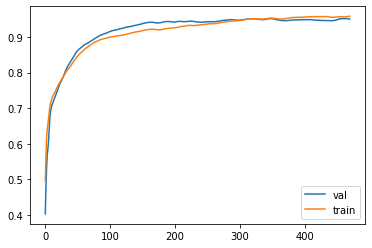

train 0.9584009021552826
val 0.9505169845937474
lr 0.00032523249517259163



In [ ]:
history_train_loss = []
history_val = []
history_train_roc = []
epochs = 5
optim = torch.optim.Adam(model.parameters())
loss_function = nn.BCELoss().to(device)
trainer.make_batch_for_valuate()
scheduler = Scheduler(optim)
lr = []

for epoch in range(epochs):
    for idx, (batch, target) in tqdm_notebook(enumerate(trainer.iterable_minibatches())):
        model.train()
        input_site = torch.FloatTensor(batch['sites']).cuda()
        input_cat = torch.tensor(batch['cat'], dtype=torch.long).float().cuda()
        input_cluster = torch.tensor(batch['cluster'], dtype=torch.long).float().cuda()
        target = torch.tensor(target).float().to(device)

        predictions = model(input_site, input_cat, input_cluster).float()
        predictions = predictions.view(predictions.size(0))
        loss = loss_function(predictions, target)

        loss.backward()
        optim.step()
        optim.zero_grad()


        history_train_loss.append(loss.data.cpu().numpy())
        history_val.append(trainer.roc_auc(model, train = False))

        scheduler.step(board = history_val[-1])
        lr.append(optim.param_groups[0]['lr'])
        
        history_train_roc.append(trainer.roc_auc(model))
        clear_output(True)
        plt.plot(history_val,label='val')
        plt.plot(history_train_roc, label = 'train')
        plt.legend()
        plt.show()
        if history_val[-1] == np.max(history_val):
          best_model = copy.deepcopy(model)
        print(f'train {history_train_roc[-1]}')
        print(f'val {history_val[-1]}')
        print(f'lr {lr[-1]}')

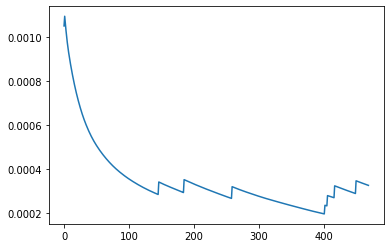

In [ ]:
plt.plot(lr)

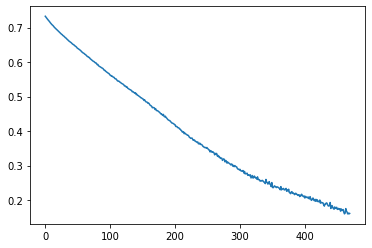

In [ ]:
plt.plot(history_train_loss, label = 'train')

In [ ]:
trainer.make_predictions_file(best_model)